In [1]:
import pandas as pd
import os
import scipy.ndimage as nd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
from keras.models import load_model
sys.path.append('./SRC')
from batch_renorm import BatchRenormalization
import random
import glob
import nibabel as nib
from collections import defaultdict
from Util import plotData,getPredictions

Using TensorFlow backend.
/home/benediktj/VirtualReality/lib/python2.7/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [4]:
path = '../Data/CAT_UK_Biobank/'
paths = glob.glob(path+'*/mri/wj*.nii')

In [5]:
len(paths)

21387

In [6]:
idToPath = defaultdict(list)
for i in paths:
    idToPath[i.split('/')[3][:7]] = idToPath[i.split('/')[3][:7]]+[i]

def loadHeader(ID,idToPath=idToPath):
    header = nib.load(idToPath[ID][0]).header
    return header

def loadMR(path):
    img = nib.load(path).get_data()
    return img

In [7]:
ids = list(idToPath.keys())

In [8]:
idFrame = pd.DataFrame.from_dict(idToPath,orient='index')
idFrame['ID'] = idFrame.index.astype(int)

In [9]:
subjectInfoPath = '../Data/ID_Gender_YOB_MOB.txt'
ageInfo = pd.read_csv('../Data/UK_Biobank_ImagingVisitAge2.txt',delim_whitespace=True)
ageInfo.columns = ['ID','Age']
#ageInfo = ageInfo.drop(['Sex','YOB'],1)
subjectInfo = pd.read_csv(subjectInfoPath,delim_whitespace=True)
subjectInfo = subjectInfo.drop(subjectInfo.index[0])
subjectInfo.columns = ['ID','gender','YOB','month']
subjectInfo = pd.merge(subjectInfo,ageInfo,how='inner',on='ID')
tmp = pd.read_csv('../Data/ukb2489_id2pn.txt',header=None,sep='\t')
tmp.columns  = ['ID','PN']
subjectInfo = pd.merge(tmp,subjectInfo,on='ID',how='inner')
data = pd.merge(subjectInfo,idFrame,how='inner',on=['ID','ID'])
data['scanner'] = np.zeros(data.shape[0])
data['gender'] = 1 - data['gender']

In [10]:
X = data[[0,'gender','scanner']].values
y = data['Age'].values

In [11]:
dataShape = (121,145,121)

In [12]:
import threading

class threadsafe_iter:
    """Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def next(self):
        with self.lock:
            return self.it.next()


def threadsafe_generator(f):
    """A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g

@threadsafe_generator
def generator(features, labels, batch_size,inputShape=(121,145,121),resize=False,augment=False):
    inputShape=(121,145,121)
    batch_T2 = np.zeros((batch_size,)+inputShape+(1,))
    scanner = np.zeros((batch_size,1))
    gender = np.zeros((batch_size,1))
    batch_labels = np.zeros((batch_size,1))
    while True:
        for i in range(batch_size):
            # choose random index in features
            index= random.choice(np.arange(labels.shape[0]))
            batch_T2[i],scanner[i],gender[i] = processing(features[index,:],inputShape,resize,augment)
            batch_labels[i] = labels[index]
        yield [batch_T2,scanner,gender], batch_labels


def resize3d(image,new_shape,order=3):
    real_resize_factor = tuple(map(operator.truediv, new_shape, image.shape))
    return nd.zoom(image, real_resize_factor, order=order)

def make_rand_vector(dims):
    vec = [gauss(0, 1) for i in range(dims)]
    mag = sum(x**2 for x in vec) ** .5
    return [x/mag for x in vec]

def coordinateTransformWrapper(X_T1,maxDeg=40,maxShift=7.5):
    randomAngle = np.radians(maxDeg*2*(random.random()-0.5))
    unitVec = tuple(make_rand_vector(3))
    shiftVec = [maxShift*2*(random.random()-0.5),
                maxShift*2*(random.random()-0.5),
                maxShift*2*(random.random()-0.5)]
    X_T1 = coordinateTransform(X_T1,randomAngle,unitVec,shiftVec)
    return X_T1

def coordinateTransform(vol,randomAngle,unitVec,shiftVec,order=1,mode='constant'):
    #from transformations import rotation_matrix
    ax = (list(vol.shape))
    ax = [ ax[i] for i in [1,0,2]]
    coords=np.meshgrid(np.arange(ax[0]),np.arange(ax[1]),np.arange(ax[2]))

    # stack the meshgrid to position vectors, center them around 0 by substracting dim/2
    xyz=np.vstack([coords[0].reshape(-1)-float(ax[0])/2,     # x coordinate, centered
               coords[1].reshape(-1)-float(ax[1])/2,     # y coordinate, centered
               coords[2].reshape(-1)-float(ax[2])/2,     # z coordinate, centered
               np.ones((ax[0],ax[1],ax[2])).reshape(-1)])    # 1 for homogeneous coordinates
    
    # create transformation matrix
    mat=rotation_matrix(randomAngle,unitVec)

    # apply transformation
    transformed_xyz=np.dot(mat, xyz)

    # extract coordinates, don't use transformed_xyz[3,:] that's the homogeneous coordinate, always 1
    x=transformed_xyz[0,:]+float(ax[0])/2+shiftVec[0]
    y=transformed_xyz[1,:]+float(ax[1])/2+shiftVec[1]
    z=transformed_xyz[2,:]+float(ax[2])/2+shiftVec[2]
    x=x.reshape((ax[1],ax[0],ax[2]))
    y=y.reshape((ax[1],ax[0],ax[2]))
    z=z.reshape((ax[1],ax[0],ax[2]))
    new_xyz=[y,x,z]
    new_vol=map_coordinates(vol,new_xyz, order=order,mode=mode)
    return new_vol

def processing(features,inputShape,resizeImg=True,augment=False,training=False):
    #meanImg = np.load('/odinn/users/benediktj/Age Prediction/Data/MeanT2ImgNew(Nipype).npy')
    #X = loadMR(features[0])-meanImg
    X = loadMR(features[0])
    scanner = features[1]
    gender = features[2]
    if resizeImg:
        inputShape = (121, 145, 121)
        X = resize3d(X,inputShape)
    if augment:
        X = coordinateTransformWrapper(X,maxDeg=40,maxShift=10)
    return X.reshape(X.shape+(1,)), scanner, gender

In [13]:
from keras.layers.merge import concatenate
import tensorflow as tf

def regression_hinge(y_true, y_pred):
    epsilon = 2
    return K.mean(K.maximum(K.abs(y_true - y_pred) - epsilon, 0.), axis=-1)

def covarModel(learningRate,decayRate=0.03,momentum=0.9,inputShape=dataShape,paddingType = 'same',initType='he_uniform',regAmount=0.00005):
    K.__dict__["gradients"] = gradients_speed
    t1Input = Input(inputShape+(1,), name='T1_Img')
    scanner  = Input((1,), name='Scanner')
    gender  = Input((1,), name='Gender')
        
    with tf.name_scope('ResBlock0'):
        inputs = t1Input
        features = 8
        hidden = Conv3D(features, (3, 3, 3), padding=paddingType,kernel_regularizer=L2(regAmount),kernel_initializer=initType)(inputs)
        hidden = BatchRenormalization(axis=-1)(hidden)
        hidden = ELU(alpha=1.0)(hidden)
        hidden = Conv3D(features, (3, 3, 3), padding=paddingType,kernel_regularizer=L2(regAmount),kernel_initializer=initType)(hidden)
        hidden = BatchRenormalization(axis=-1)(hidden)
        shortcut = Conv3D(features, (1,1,1), strides=(1,1,1), padding=paddingType,kernel_initializer=initType)(inputs)
        hidden = add([shortcut,hidden])
        outputs = ELU(alpha=1.0)(hidden)
        
    pooling = MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2), padding=paddingType)(outputs)
    
    with tf.name_scope('ResBlock1'):
        inputs = pooling
        features = 16
        hidden = Conv3D(features, (3, 3, 3), padding=paddingType,kernel_regularizer=L2(regAmount),kernel_initializer=initType)(inputs)
        hidden = BatchRenormalization(axis=-1)(hidden)
        hidden = ELU(alpha=1.0)(hidden)
        hidden = Conv3D(features, (3, 3, 3), padding=paddingType,kernel_regularizer=L2(regAmount),kernel_initializer=initType)(hidden)
        hidden = BatchRenormalization(axis=-1)(hidden)
        shortcut = Conv3D(features, (1,1,1), strides=(1,1,1), padding=paddingType,kernel_initializer=initType)(inputs)
        hidden = add([shortcut,hidden])
        outputs = ELU(alpha=1.0)(hidden)
        
    pooling = MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2), padding=paddingType)(outputs)

    with tf.name_scope('ResBlock2'):
        inputs = pooling
        features = 32
        hidden = Conv3D(features, (3, 3, 3), padding=paddingType,kernel_regularizer=L2(regAmount),kernel_initializer=initType)(inputs)
        hidden = BatchRenormalization(axis=-1)(hidden)
        hidden = ELU(alpha=1.0)(hidden)
        hidden = Conv3D(features, (3, 3, 3), padding=paddingType,kernel_regularizer=L2(regAmount),kernel_initializer=initType)(hidden)
        hidden = BatchRenormalization(axis=-1)(hidden)
        shortcut = Conv3D(features, (1,1,1), strides=(1,1,1), padding=paddingType,kernel_initializer=initType)(inputs)
        hidden = add([shortcut,hidden])
        outputs = ELU(alpha=1.0)(hidden)
        
    pooling = MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2), padding=paddingType)(outputs)
    
    with tf.name_scope('ResBlock3'):
        inputs = pooling
        features = 64
        hidden = Conv3D(features, (3, 3, 3), padding=paddingType,kernel_regularizer=L2(regAmount),kernel_initializer=initType)(inputs)
        hidden = BatchRenormalization(axis=-1)(hidden)
        hidden = ELU(alpha=1.0)(hidden)
        hidden = Conv3D(features, (3, 3, 3), padding=paddingType,kernel_regularizer=L2(regAmount),kernel_initializer=initType)(hidden)
        hidden = BatchRenormalization(axis=-1)(hidden)
        shortcut = Conv3D(features, (1,1,1), strides=(1,1,1), padding=paddingType,kernel_initializer=initType)(inputs)
        hidden = add([shortcut,hidden])
        outputs = ELU(alpha=1.0)(hidden)
        
        
    pooling = MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2), padding=paddingType)(outputs)
    
    with tf.name_scope('ResBlock4'):
        inputs = pooling
        features = 128
        hidden = Conv3D(features, (3, 3, 3), padding=paddingType,kernel_regularizer=L2(regAmount),kernel_initializer=initType)(inputs)
        hidden = BatchRenormalization(axis=-1)(hidden)
        hidden = ELU(alpha=1.0)(hidden)
        hidden = Conv3D(features, (3, 3, 3), padding=paddingType,kernel_regularizer=L2(regAmount),kernel_initializer=initType)(hidden)
        hidden = BatchRenormalization(axis=-1)(hidden)
        shortcut = Conv3D(features, (1,1,1), strides=(1,1,1), padding=paddingType,kernel_initializer=initType)(inputs)
        hidden = add([shortcut,hidden])
        outputs= ELU(alpha=1.0)(hidden)
        
    pooling = MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2), padding=paddingType)(outputs)
        
    hidden = Flatten()(pooling)
    
    hidden = Dense(128,kernel_regularizer=L2(regAmount),kernel_initializer=initType,name='FullyConnectedLayer')(hidden)
    hidden = ELU(alpha=1.0)(hidden)
    hidden = Dropout(0.2)(hidden)
    
    hidden = concatenate([scanner,gender,hidden])
    
    prediction = Dense(1,kernel_regularizer=L2(regAmount), name='AgePrediction')(hidden)
    model = Model(inputs=[t1Input,scanner,gender],outputs=prediction)
    adam = Adam(lr=learningRate, decay=decayRate)
    
    model.compile(loss='mean_absolute_error',optimizer=adam,metrics=['mae','mse'])
    return model

In [14]:
def plotLayerWeights(model,layerNr=1):
    #x1w = model.get_layer(index=layerNr).get_weights()[0][:,:,:,0,:]
    x1w = model.get_layer(index=layerNr).get_weights()[0][:,:,:,:,:]
    numberOfFeatureMaps = x1w[:,:,1,:,:].shape[3]
    grayOrWhite = ['Gray Matter','White Matter']
    for i in range(0,numberOfFeatureMaps):
        for k in range(2):
            print('Kernel Nr. '+str(i+1)+' :'+grayOrWhite[k])
            for j in range(0,3):
                plt.subplot(1,3,j+1)
                plt.imshow(x1w[:,:,j,k,i],interpolation="nearest",cmap="gray")
            plt.show()
        

def getFeatureMaps(model,features,layerNr=27,subjectNr=1,figSize=(20,10),max_iLen=None,max_jLen=None,c=0,d=1,inputShape=dataShape):
    intermediate_layer_model = Model(input = model.input, output = model.get_layer(index=layerNr).output)
    t1_img,scanner,gender = getBatchData(features[subjectNr:subjectNr+1,:],1,resizeImg=True)
    intermediate_output = intermediate_layer_model.predict([t1_img,scanner,gender])
    print(intermediate_output.shape)
    iLen = intermediate_output.shape[4]
    jLen = intermediate_output.shape[3]
    if max_iLen!=None:
        iLen = max_iLen
    if max_iLen!=None:
        jLen = max_jLen
    for i in range(iLen):
        print('Feature map nr. '+str(i))
        plt.figure(figsize=figSize)
        for j in range(jLen):
            plt.subplot(1,jLen,j+1)
            plt.imshow(intermediate_output[0,:,:,d*(j+c),i],interpolation="spline16",cmap="gray")
        plt.show()

        
def plotData(features,subjectNr=1,c=5,d = 12,nSlices = 10,figsize=(20,10),inputShape=dataShape,augment=False,training=False,resize=True):
    batch_data,_,_ = getBatchData(features[subjectNr:subjectNr+1,:], 1,inputShape=dataShape,resizeImg=resize,augment=augment)
    fig,axs = plt.subplots(1, nSlices,figsize=figsize)
    for i in range(nSlices):
        axs[i].imshow(batch_data[0,:,:,d*(i+c),0],interpolation="spline16",cmap='gray')
    plt.show()        

    
def getBatchData(features, batch_size,inputShape=dataShape,resizeImg=False,augment=False):
    inputShape=(121, 145, 121)
    batch_T1 = np.zeros((batch_size,)+inputShape+(1,))
    scanner = np.zeros((batch_size,1))
    gender = np.zeros((batch_size,1))
    batch_labels = np.zeros((batch_size,1))
    index=0
    for i in range(batch_size):
        batch_T1[i],scanner[i],gender[i] = processing(features[i,:],inputShape,resizeImg,augment)
        index=1+index
    return batch_T1,scanner,gender


def getPredictions(model,X,inputShape=dataShape,batchSize=1,resizeImg=False,roundPredictions=False):
    predictions = np.array([])
    X = np.array_split(X, X.shape[0]/batchSize)
    for i,batch in enumerate(X):
        #plotData(X,subjectNr=i,augment=False,resize=False,c=2,d=10,nSlices=8)
        if i%250==0:
            print(i)
        img,scanner,gender = getBatchData(batch,batch.shape[0],resizeImg=resizeImg)
        if roundPredictions:
            predictions = np.append(predictions,int(model.predict([img,scanner,gender],1)))
        else:
            pred = model.predict([img,scanner,gender],batch_size=batch.shape[0])
            #print(pred)
            predictions = np.append(predictions,pred)
    return predictions

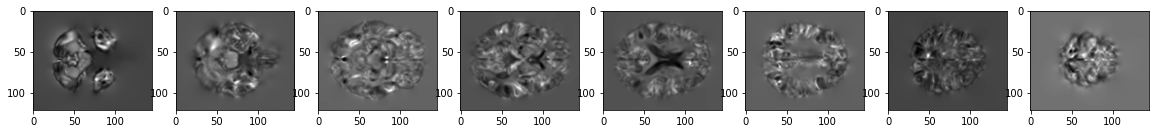

In [15]:
plotData(X,subjectNr=0,augment=False,resize=False,c=2,d=10,nSlices=8)

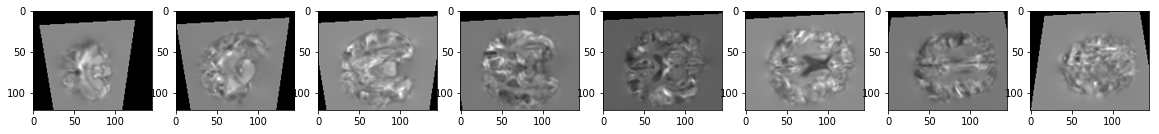

In [22]:
plotData(X,subjectNr=0,augment=True,resize=False,c=2,d=10,nSlices=8)

Fist let's try the model only trained on the Icelandic data

In [19]:
model = load_model('../Models/BrainAgeResNet(Jac)(Ice)')

0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
5000
5250
5500
5750
6000
6250
6500
6750
7000
7250
7500
7750
8000
8250
8500
8750
9000
9250
9500
9750
10000
10250
10500
10750
11000
11250
11500
11750
12000
12250
('Validation R^2: ', -1.2626974300906473)
('Validation MAE: ', 9.794305956923843)


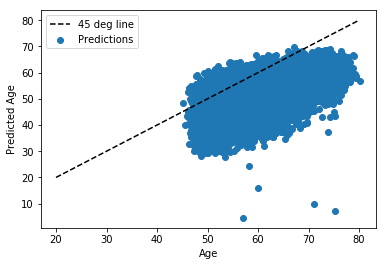

In [20]:
n = X.shape[0]
predictions = getPredictions(model,X[:n,:],batchSize=1)
print('Validation R^2: ',r2_score(y[:n],predictions))
print('Validation MAE: ',mean_absolute_error(y[:n],predictions))
plt.scatter(y[:n],predictions,label='Predictions')
y_range = np.arange(20,np.max(y[:n]))
plt.plot(y_range,y_range,c='black',ls='dashed',label='45 deg line')
plt.xlabel('Age')
plt.ylabel('Predicted Age')
plt.legend()
#plt.savefig('../../Results/Images/ConvolutionalNeuralNet/T1/UKBioCATValidationScatterPlot_AllButLastrozen', bbox_inches='tight')
plt.show()

In [21]:
brainAge = pd.DataFrame({'Asc':data['ID'].values,'PredictedBrainAge':np.array(predictions)},index = data['ID'])
brainAge.to_csv('../Results/Jac_CNN_NoTL_pred.txt',sep='\t')

Now let's try the model trained on the Icelandic data and IXI.

In [22]:
model = load_model('../Models/BrainAgeResNet(Jac)(IceAndIXI)')

0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
5000
5250
5500
5750
6000
6250
6500
6750
7000
7250
7500
7750
8000
8250
8500
8750
9000
9250
9500
9750
10000
10250
10500
10750
11000
11250
11500
11750
12000
12250
('Validation R^2: ', 0.02288632718218564)
('Validation MAE: ', 5.822154688952632)


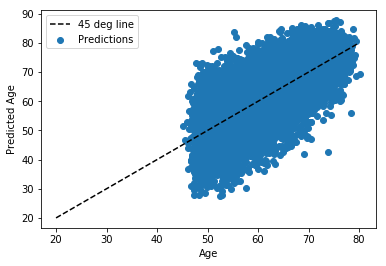

In [23]:
n = X.shape[0]
predictions = getPredictions(model,X[:n,:],batchSize=1)
print('Validation R^2: ',r2_score(y[:n],predictions))
print('Validation MAE: ',mean_absolute_error(y[:n],predictions))
plt.scatter(y[:n],predictions,label='Predictions')
y_range = np.arange(20,np.max(y[:n]))
plt.plot(y_range,y_range,c='black',ls='dashed',label='45 deg line')
plt.xlabel('Age')
plt.ylabel('Predicted Age')
plt.legend()
plt.show()

In [24]:
brainAge = pd.DataFrame({'Asc':data['ID'].values,'PredictedBrainAge':np.array(predictions)},index = data['ID'])
brainAge.to_csv('../Results/Jac_CNN_WithTL_pred.txt',sep='\t')